# Visualizing Activations

In [2]:
import sys
sys.path.append('../')

from deps.saeai.sae_auto_interp.utils import load_tokenized_data
from deps.saeai.sae_auto_interp.features import FeatureRecord
from deps.saeai.sae_auto_interp.explainers import SimpleExplainer, ExplainerInput
# from deps.saeai.sae_auto_interp.clients import get_client, execute_model

from settings import settings

import torch
from nnsight import LanguageModel
import numpy as np
from sklearn.linear_model import LinearRegression
import random

from io import BytesIO
import base64
import os

import matplotlib.pyplot as plt
from IPython.display import display, HTML

/Users/aathreyakadambi/Documents/software/python/anaconda/anaconda3/envs/llm-sae-interp-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


datasets:
"stas/openwebtext-10k"
"kh4dien/fineweb-100m-sample"

In [3]:
# general variables
oai_sae_path = os.path.join(settings["oai_autoencoder_dir"], "gpt2-small/resid_post_mlp_v5_32k/")
cache_dir = os.path.join(settings["feature_dir"], "raw_features/")

layers = range(0, 7, 2)

In [4]:
model = LanguageModel("openai-community/gpt2", device_map="cpu", dispatch=True)
tokens = load_tokenized_data(model.tokenizer, dataset_repo="kh4dien/fineweb-100m-sample", dataset_split="train[:15%]")

In [5]:
raw_features_path = cache_dir
processed_features_path = "processed_features"
random.seed(22)
explainer_inputs = []

In [6]:
def color_text(text, intensity=0.5):
    intensity = max(0.0, min(1.0, intensity))
    color_value = int(255 * intensity)
    color_hex = f"#595388{color_value:02x}"
    return f'<span style="background-color: {color_hex};">{text}</span>'

def format_tokens_with_activations(tokens, activations):
    tokenizer = model.tokenizer

    html_content = f""
    for i in range(len(tokens)):
        piece = tokenizer.convert_ids_to_tokens(int(tokens[i]))
        piece = color_text(piece, activations[i])
        html_content += piece
    return html_content.replace('Ġ', ' ')

def display_tokens_with_activations(tokens, activations):
    display(HTML(format_tokens_with_activations(tokens, activations)))

In [7]:
def display_feature_activations(feature_number):
    records = []
    for layer in layers:
        module_name = f"layer{layer}"

        records.append(FeatureRecord.from_tensor(
            tokens,
            module_name,
            selected_features=[feature_number],
            raw_dir = raw_features_path,
            min_examples=200,
            max_examples=10000
        ))

        for record in records[-1]:

            examples = record.examples
            for example in examples:
                normalized_activations = (example.activations / record.max_activation)*10
                example.normalized_activations = normalized_activations.round()
            top_200 = examples[:200]
            random_20 = random.sample(examples, 20)
            random_top_200_20 = random.sample(top_200,20)
            split_top_200_20_all_20 = random_top_200_20 + random_20

            explainer_inputs.append(ExplainerInput(
                train_examples=split_top_200_20_all_20,
                record=record
            ))

    counter = 0

    for record in records[1]:
        examples = record.examples
        for example in examples:
            if counter > 10: 
                break
            counter += 1
            example_tokens = example.tokens
            activations = example.normalized_activations
            display_tokens_with_activations(example_tokens.numpy(), activations.numpy())
        break


In [8]:
display_feature_activations(200)

Loading features from tensor for layer layer6: 100%|██████████| 1/1 [00:00<00:00, 24.12it/s]


In [9]:
def get_distribution(feature_number):
    records = []
    for layer in layers:
        module_name = f"layer{layer}"

        records.append(FeatureRecord.from_tensor(
            tokens,
            module_name,
            selected_features=[feature_number],
            raw_dir = raw_features_path,
            min_examples=200,
            max_examples=10000
        ))

        for record in records[-1]:

            examples = record.examples
            for example in examples:
                normalized_activations = (example.activations / record.max_activation)*10
                example.normalized_activations = normalized_activations.round()
            top_200 = examples[:200]
            random_20 = random.sample(examples, 20)
            random_top_200_20 = random.sample(top_200,20)
            split_top_200_20_all_20 = random_top_200_20 + random_20

            explainer_inputs.append(ExplainerInput(
                train_examples=split_top_200_20_all_20,
                record=record
            ))
    
    all_activations = []
    for record in records[1]:
        examples = record.examples
        for example in examples:
            normalized_activations = (example.activations / record.max_activation)*10
            normalized_activations = normalized_activations[normalized_activations != 0]
            all_activations.extend(normalized_activations)
        break 
    return all_activations

In [10]:
dist = get_distribution(428)

Loading features from tensor for layer layer6: 100%|██████████| 1/1 [00:00<00:00, 40.93it/s]


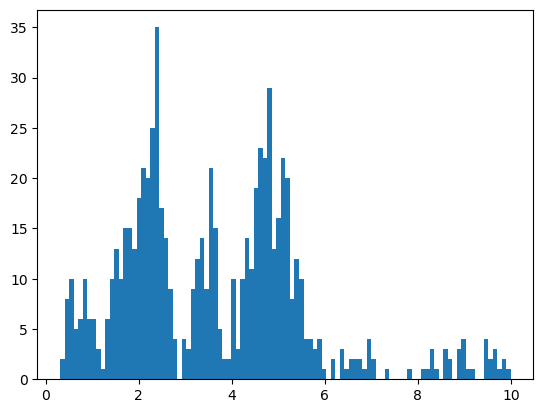

In [11]:
plt.hist(dist, bins=100);

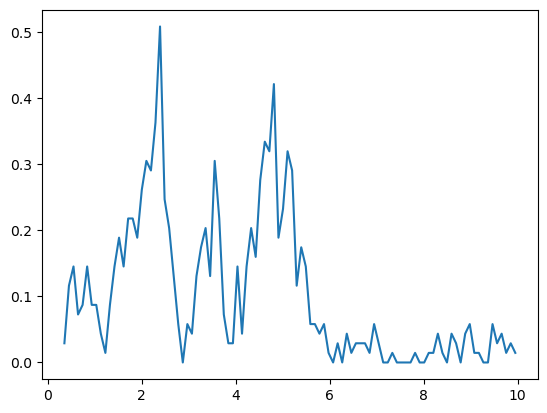

In [13]:
counts, bin_edges = np.histogram(dist, bins=100, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.plot(bin_centers, counts, label='Smoothed Histogram')
plt.show()

In [14]:
def plot_to_base64():
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')  # Save with tight bounding box
    buf.seek(0)
    img_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')
    buf.close()
    return img_base64

In [17]:
def get_dist_and_feature_acts(feature_number):
    records = []
    for layer in layers:
        module_name = f"layer{layer}"

        records.append(FeatureRecord.from_tensor(
            tokens,
            module_name,
            selected_features=[feature_number],
            raw_dir = raw_features_path,
            min_examples=200,
            max_examples=10000
        ))

        for record in records[-1]:

            examples = record.examples
            for example in examples:
                normalized_activations = (example.activations / record.max_activation)*10
                example.normalized_activations = normalized_activations.round()
            top_200 = examples[:200]
            random_20 = random.sample(examples, 20)
            random_top_200_20 = random.sample(top_200,20)
            split_top_200_20_all_20 = random_top_200_20 + random_20

            explainer_inputs.append(ExplainerInput(
                train_examples=split_top_200_20_all_20,
                record=record
            ))

    dist = []
    for record in records[1]:
        examples = record.examples
        for example in examples:
            normalized_activations = (example.activations / record.max_activation)*10
            normalized_activations = normalized_activations[normalized_activations != 0]
            dist.append(sum(normalized_activations))
        break 

    counts, bin_edges = np.histogram(dist, bins=100, density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, counts, label='Smoothed Histogram')
    plt.xlabel("Activation")
    plt.ylabel("Frequency")
    plt.title("Activations for Feature " + str(feature_number))

    # Adjust the layout to make room for the text
    counter = 0

    res = f''
    for record in records[1]:
        examples = record.examples
        for example in examples:
            if counter > 10: 
                break
            counter += 1
            example_tokens = example.tokens
            activations = example.normalized_activations
            res += format_tokens_with_activations(example_tokens.numpy(), activations.numpy()) + "<br />"
        break

    img_base64 = plot_to_base64()
    return img_base64, res

Loading features from tensor for layer layer6: 100%|██████████| 1/1 [00:00<00:00, 60.47it/s]


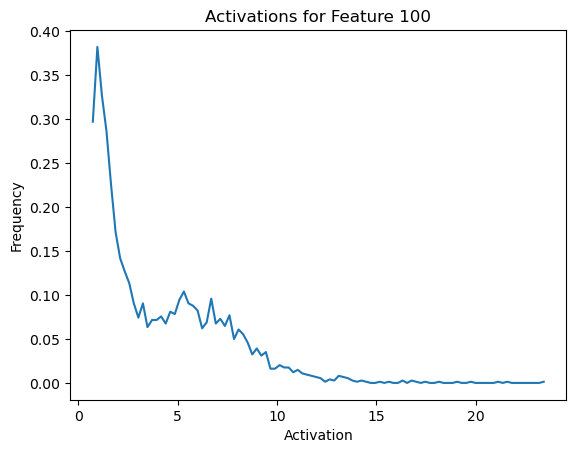

In [18]:
plot, text = get_dist_and_feature_acts(100)
display(HTML(text))

In [20]:
# HTML content with placeholders for plot images and text
html_template = """
  <html>
    <head>
      <style>
        body {{
          font-family: Arial, sans-serif;
        }}
        .content {{
          margin: 20px;
          border: 1px solid black;
          padding: 3%;
        }}
        img {{
          max-width: 100%;
          height: auto;
        }}
      </style>
    </head>
    <body>
      <div class="content" id="feature_{plot_num}">
        <h1>Feature {plot_num}</h1>
        <h2>Distribution of Sums of Activations Per Sentence</h2>
        <img src="data:image/png;base64,{plot_data}" alt="Plot {plot_num}">
        <div>
          <h2>Activating Tokens in Examples</h2>
          {text}
        </div>
      </div>
    </body>
  </html>
  """

html_content = ""
for i in range(10):
  plot_data, text = get_dist_and_feature_acts(i)
  html_content += html_template.format(plot_num=i, plot_data=plot_data, text=text)
  plt.close()

with open('output.html', 'w') as f:
  f.write(html_content)

Loading features from tensor for layer layer6: 100%|██████████| 1/1 [00:00<00:00, 33.01it/s]


In [45]:
feature_number = 245

In [48]:
records = []
res = f''
for layer in layers:
    module_name = f"layer{layer}"

    records.append(FeatureRecord.from_tensor(
        tokens,
        module_name,
        selected_features=[feature_number],
        raw_dir = raw_features_path,
        min_examples=200,
        max_examples=10000
    ))

    for record in records[-1]:

        examples = record.examples
        for example in examples:
            normalized_activations = (example.activations / record.max_activation)*10
            example.normalized_activations = normalized_activations.round()
        top_200 = examples[:200]
        bottom_200 = examples[-200:]
        random_20 = random.sample(examples, 20)
        random_top_200_20 = random.sample(top_200,20)
        split_top_200_20_all_20 = random_top_200_20 + random_20

        for example in top_200:
            example_tokens = example.tokens
            activations = example.normalized_activations
            res += format_tokens_with_activations(example_tokens.numpy(), activations.numpy()) + "<br />"

        explainer_inputs.append(ExplainerInput(
            train_examples=split_top_200_20_all_20,
            record=record
        ))

Loading features from tensor for layer layer6: 100%|██████████| 1/1 [00:00<00:00, 16.35it/s]


In [49]:
display(HTML(res))